In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Import Data

In [6]:
dataset = pd.read_csv('DailyDelhiClimateTrain.csv',parse_dates=['date'], usecols = ['date','meantemp'])

### EDA & Preprocessing

In [13]:
#Column names needed to Prophet
dataset.columns = ['ds','y']

In [14]:
#ds needs to be datetime data type
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1462 non-null   datetime64[ns]
 1   y       1462 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 23.0 KB


In [15]:
dataset.isnull().sum()

ds    0
y     0
dtype: int64

In [94]:
#Test & train datasets

train = dataset.iloc[:len(dataset)-367]
test = dataset.iloc[len(dataset)-367:-1]

<AxesSubplot:>

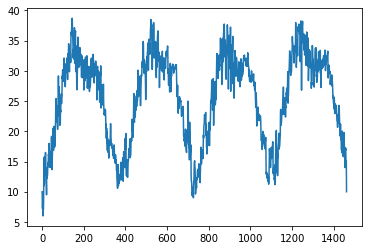

In [197]:
dataset.y.plot()

### Prophet Model

In [1]:
from fbprophet import Prophet

In [213]:
m = Prophet(seasonality_mode='additive')

m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [214]:
# Placeholder to hold future predictions

future = m.make_future_dataframe(periods = 366)

In [215]:
#make predictions

fcast = m.predict(future)

In [216]:
fcast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [217]:
fcast_reduced = fcast[['ds','yhat_lower', 'yhat_upper','yhat']]

(15706.0, 17166.0)

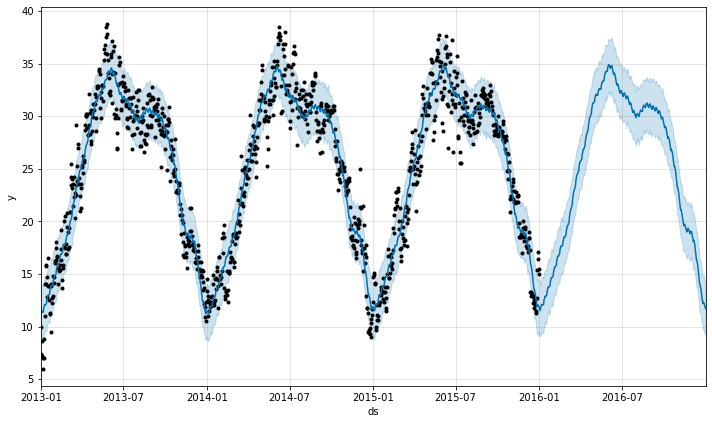

In [218]:
m.plot(fcast);
plt.xlim(fcast_reduced.ds[0],fcast_reduced.ds[len(fcast)-1])

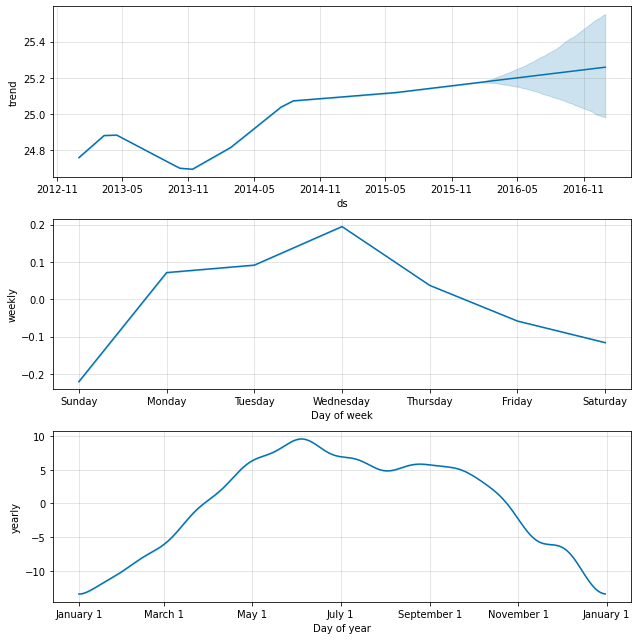

In [219]:
m.plot_components(fcast);

### Trend Changes

In [222]:
from fbprophet.plot import add_changepoints_to_plot

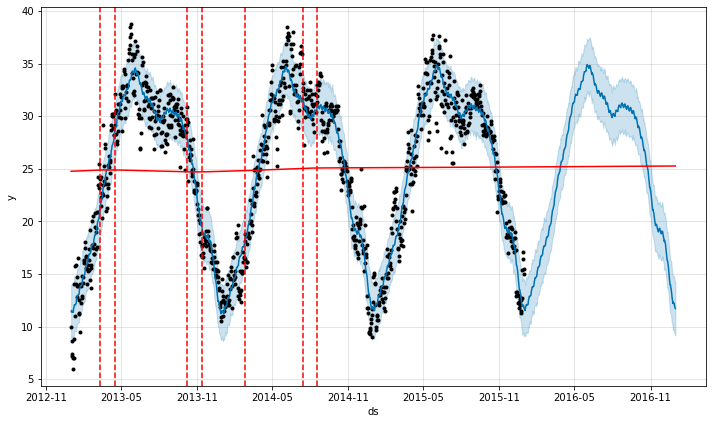

In [223]:
fig = m.plot(fcast)

a = add_changepoints_to_plot(fig.gca(),m,fcast)

### Performance

<AxesSubplot:xlabel='ds'>

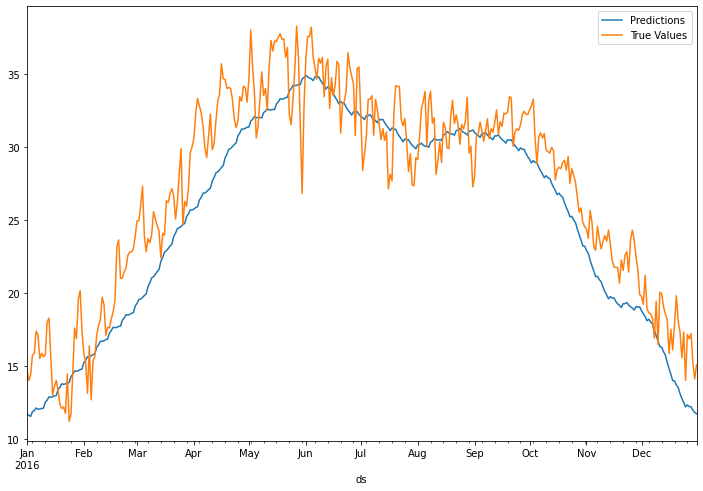

In [224]:
ax = fcast_reduced.plot(x = 'ds', y = 'yhat', label = 'Predictions', legend = True, figsize = (12,8))

test.plot(x = 'ds', y = 'y', label = 'True Values', legend = True
                                                  , ax = ax, xlim =('2016-01-01 00:00:00','2016-12-31 00:00:00') )

In [225]:
from statsmodels.tools.eval_measures import rmse

In [226]:
predictions = fcast_reduced.iloc[-366:]['yhat']

In [227]:
print('RMSE:',rmse(predictions,test.y))
print('Average Temperature:',dataset.y.mean())

RMSE: 2.9228019344758223
Average Temperature: 25.495520655761762


### Cross Validation 

In [228]:
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [229]:
# Initial  (initial period)
initial =  365
initial = str(initial) + 'days'

#Period (how many time fold)
period = 90
period = str(period) + 'days'

#Horizon (How far out to forecast)
horizon = 365
horizon = str(horizon) + 'days'

In [230]:
df_cv = cross_validation(m,initial = initial ,period = period  ,horizon = horizon )

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-01-05 00:00:00 and 2014-12-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

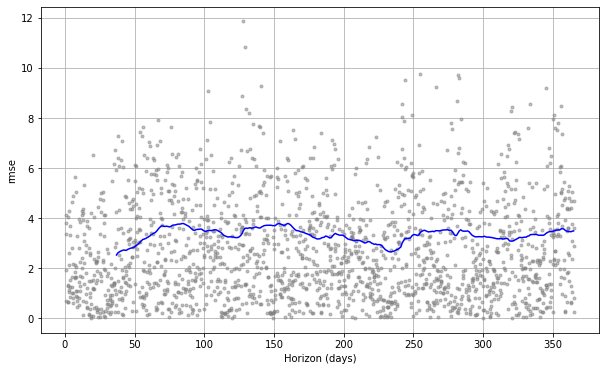

In [173]:
plot_cross_validation_metric(df_cv, metric ='rmse');

In [231]:
performance = performance_metrics(df_cv)
print('Cross Validation:',performance.rmse.mean())

Cross Validation: 3.3264738454086027
